# AML Project - Slot Attention Transformer

Model parameters

In [1]:
# TODO:

# Add learning rate scheduler
# Experiment with num_slots for cropped images
# Try L1Loss instead of MSE (or combination)
# More data augmentations
# Add more layers to decoder

# Combine 01 and 02 datasets
# Maybe add another loss?
# Learning rate warm up?
# Check attn_maps output segmentation
# Implement option for non-adaptive slots


# git add .
# git commit -m "Comment"
# git push origin main


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


from fullmodel import FullModel
from train import trainmodel
from utils import show_images, plot_results, print_parameters, get_loaders_split


%load_ext autoreload
%autoreload 2


IMG_DIR = "celldata/02"
MASK_DIR = "celldata/02_ST/SEG"

# HYPERPARAMETERS
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True
LOAD_MODEL = False
NUM_WORKERS = 0

BATCH_SIZE = 8
NUM_EPOCHS = 2

IMG_SIZE = 128
IMG_C = 1
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
CROP_SIZE = 256
CROP_HEIGHT = CROP_SIZE
CROP_WIDTH = CROP_SIZE
CROP_SIZE = (CROP_HEIGHT, CROP_WIDTH)
# CROP_SIZE = None

ENCODER_FEATURES = [32, 64, "pool", 64]
ENCODER_OUT_CHANNELS = 64 # = slot_dim
NUM_SLOTS = 8
NUM_HEADS = 2
DIM_HEAD = 16
SLOT_ITERATIONS = 2
HIDDEN_DIM = 32
TEMPERATURE = 0.5
DECODER_FEATURES = [64, 32, "up" 32]

LAMBDA_AUX = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Initialize data and create dataloaders

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


from fullmodel import FullModel
from train import trainmodel
from utils import show_images, plot_results, print_parameters, get_loaders_split


%load_ext autoreload
%autoreload 2


IMG_DIR = "celldata/02"
MASK_DIR = "celldata/02_ST/SEG"

# HYPERPARAMETERS
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True
LOAD_MODEL = False
NUM_WORKERS = 0

BATCH_SIZE = 1
IMG_SIZE = 128
IMG_C = 1
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
CROP_SIZE = 256
CROP_HEIGHT = CROP_SIZE
CROP_WIDTH = CROP_SIZE
# CROP_HEIGHT = OG_HEIGHT
# CROP_WIDTH = OG_WIDTH
CROP_SIZE = (CROP_HEIGHT, CROP_WIDTH)
# CROP_SIZE = None

ENCODER_FEATURES = [32, "pool", 64, 64, "pool", 128, 128, "pool", 256] # Try without pooling
ENCODER_OUT_CHANNELS = 256 # = slot_dim
NUM_SLOTS = 128
NUM_HEADS = 4
DIM_HEAD = 64 # good starting point: slot_dim / num_heads
SLOT_ITERATIONS = 4
HIDDEN_DIM = 128
TEMPERATURE = 0.5
DECODER_FEATURES = [256, "up", 128, 128, "up", 64, 64, 64, "up", 32] # No upsample

In [2]:
import torchvision.transforms as T
from PIL import Image

train_image_transform = T.Compose(
    [
        # T.ToPILImage(),
        T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.BILINEAR),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomVerticalFlip(p=0.5),
        T.Grayscale(IMG_C),
        T.ToTensor()
    ]
)

train_mask_transform = T.Compose(
    [
        # T.ToPILImage(),
        T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
        T.ToTensor()
    ]
)

val_image_transform = T.Compose(
    [
        # T.ToPILImage(),
        T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.BILINEAR),
        T.Grayscale(IMG_C),
        T.ToTensor()
    ]
)

val_mask_transform = T.Compose(
    [
        # T.ToPILImage(),
        T.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
        T.Grayscale(IMG_C),
        T.ToTensor()
    ]
)

train_loader, val_loader = get_loaders_split(
        IMG_DIR,
        MASK_DIR,
        val_split=0.2,
        random_seed=3,
        batch_size=BATCH_SIZE,
        train_image_transform=train_image_transform,
        train_mask_transform=train_mask_transform,
        val_image_transform=val_image_transform,
        val_mask_transform=val_mask_transform,
        crop_size=CROP_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )

Total images: 92
Training images: 74
Validation images: 18


Plot some images and masks

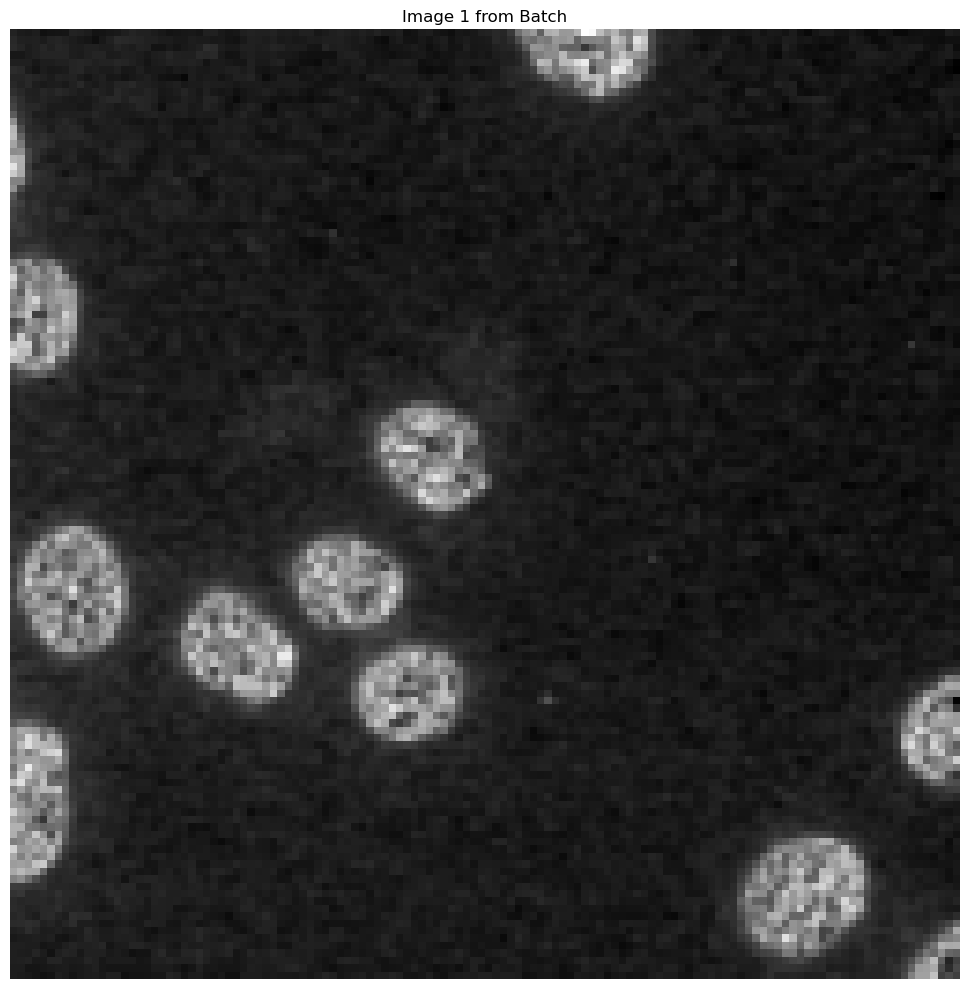

tensor(0.8431, device='cuda:0')
tensor(0.0667, device='cuda:0')


In [3]:
images, masks = next(iter(train_loader))
images = images.to(DEVICE)

num_imgs = 4

show_images(images, num_imgs)
# show_images(masks, num_imgs)

print(torch.max(images))
print(torch.min(images))

## Model

In [4]:
model = FullModel(
    IMG_C,
    IMG_HEIGHT,
    IMG_WIDTH,
    ENCODER_FEATURES,
    ENCODER_OUT_CHANNELS,
    NUM_SLOTS,
    NUM_HEADS,
    DIM_HEAD,
    SLOT_ITERATIONS,
    HIDDEN_DIM,
    TEMPERATURE,
    DECODER_FEATURES
) .to(DEVICE)

print_parameters(model)

--------Model Parameters--------
Full Model:
---> Trainable parameters: 3155.3K

(1) CNN Encoder:
---> Trainable parameters: 1163.4K
(2) Positional Encoder:
---> Trainable parameters: 0.0K
(3.1) Multihead Slot Attention:
---> Trainable parameters: 791.6K
(3.2) Adadtive Slot Wrapper:
---> Trainable parameters: 0.5K
(4) CNN Decoder:
---> Trainable parameters: 1199.8K

Total: 3155.3K trainable paramters, 0 non-trainable parameters


## Training

Done training


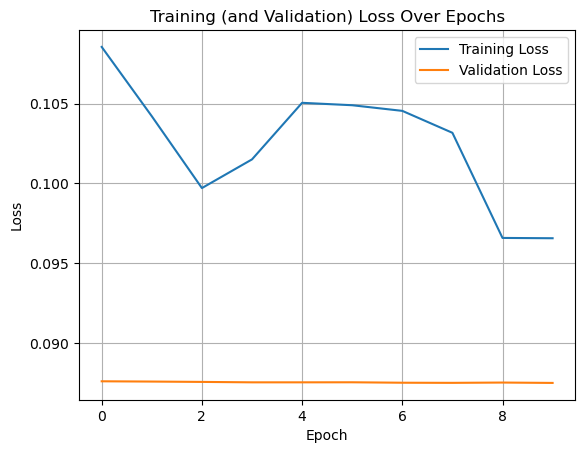

In [47]:
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10
LAMBDA_AUX = 0


loss_fn = nn.MSELoss() # For multiple classes use CrossEntropyLoss (and more out_channels)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode='min',
    factor=0.5,
    patience=15,
    min_lr=1e-6
)
scheduler_type = "plateau"

trainmodel(train_loader, val_loader, model, loss_fn, LAMBDA_AUX, optimizer, scheduler, scheduler_type, num_epochs=NUM_EPOCHS, device=DEVICE)

## Plot results

Load model

In [5]:
state_dict = torch.load(r'C:\Users\Elon\Downloads\model20may.pth', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
x_out, attn_maps, keep_slots = model(images)

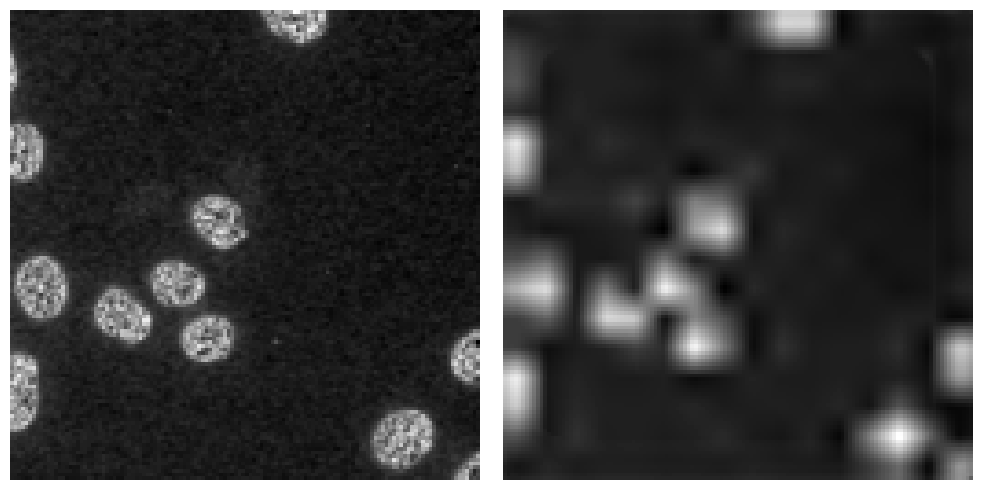

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

img = images[0].detach().cpu().numpy()
img = np.squeeze(img, axis=0)

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')

img_out = x_out[0].detach().cpu().numpy()
img_out = np.squeeze(img_out, axis=0)

plt.subplot(1, 2, 2)
plt.imshow(img_out, cmap="gray")
plt.axis('off')

plt.tight_layout()

In [21]:
print(torch.sum(keep_slots))

tensor(40., device='cuda:0', grad_fn=<SumBackward0>)
